In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [435]:
# Device (or pod) stats.
# device = dict(name='H100 SXM5',
#               flop_per_sec_8bit=2000e12,
#               net_Bps=900e9,
#               base_util=0.8) # ~20% thermal throttling

device = dict(name='64×H100 SXM5',
              flop_per_sec_8bit=64*2000e12,
              net_Bps=900e9,
              base_util=0.8) # ~20% thermal throttling

# Training run stats.
bytewidth = 1
run_flop = 1e27
hidden_factor = 5

In [436]:
# Model and training run.
N = np.sqrt(run_flop/120)          # number of parameters
D = 20*N                           # number of training tokens
B = 4e6 * (run_flop/1e25)**(1/6)   # batch size
L = 120 * (run_flop/1e25)**(1/6)   # number of layers
d = np.sqrt(N/(2*hidden_factor*L)) # residual dimension

In [437]:
all_reduce_factor = 4                 # (reduce + bcast)*(tx + rx)

# Per-layer, per token bandwidth cost factors for parallelism methods.
pp_factor = 4*d/L                     # (fwd + bwd)*(tx + rx)
tp_factor = 2*d*all_reduce_factor     # fwd + bwd
tp2_factor = hidden_factor*tp_factor
dp_factor = N/(L*B)*all_reduce_factor # once per batch

def get_bytes_per_token_per_layer(pp, tp, tp2, dp):
    return bytewidth * ((pp - 1)*pp_factor + (tp - 1)*tp_factor + (tp2 - 1)*tp2_factor + (dp - 1)*dp_factor)

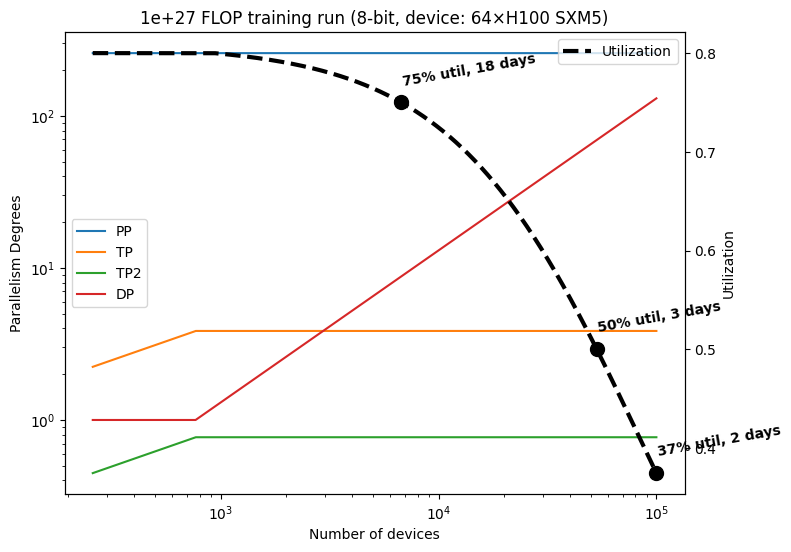

In [442]:
n_devices = 10**np.arange(np.log10(L), 5, 0.001)

# First try only methods which can overlap with computation, maxing out
# pipeline parallelism first, then tensor parallelism.
pp = np.full(len(n_devices), L)
tp = np.sqrt(hidden_factor*n_devices/pp)
tp2 = tp/hidden_factor
dp = np.ones(len(n_devices))

# Now determine if in fact they fully overlap with computation, and if not,
# we replace additional parallelism with data parallelism.
bytes_per_token_per_layer = get_bytes_per_token_per_layer(pp, tp, tp2, dp)
bptpl1 = bytes_per_token_per_layer
flop_eqv_per_token_per_layer = bytewidth*6*N/L # (fwd + 2 back)*(mul + add)
overlap = bytes_per_token_per_layer/device['net_Bps'] <= flop_eqv_per_token_per_layer/(device['base_util']*device['flop_per_sec_8bit'])
tp[~overlap] = tp[overlap].max()
tp2[~overlap] = tp2[overlap].max()
dp = n_devices/(pp*tp*tp2)

# Finally, determine if we have too much data parallelism, and if so, trade it
# for more tensor parallelism.
too_much_dp = dp*dp_factor > tp*tp_factor
common_cost = (tp_factor*tp2_factor*dp_factor*n_devices/pp)**(1/3)
tp[too_much_dp] = common_cost[too_much_dp]/tp_factor
tp2[too_much_dp] = common_cost[too_much_dp]/tp2_factor
dp[too_much_dp] = common_cost[too_much_dp]/dp_factor

# Compute utilization and training run duration.
bytes_per_token_per_layer = get_bytes_per_token_per_layer(pp, tp, tp2, dp)
bptpl2 = bytes_per_token_per_layer
util = device['base_util']*np.minimum(1, (flop_eqv_per_token_per_layer/(device['base_util']*device['flop_per_sec_8bit'])) / (bytes_per_token_per_layer/device['net_Bps']))
util[overlap] = device['base_util']
duration_secs = (run_flop*bytewidth)/(util*device['flop_per_sec_8bit']*n_devices)
duration_days = duration_secs/86400

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'{run_flop} FLOP training run ({bytewidth*8}-bit, device: {device["name"]})')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Parallelism Degrees')
ax.plot(n_devices, pp, label='PP')
ax.plot(n_devices, tp, label='TP')
ax.plot(n_devices, tp2, label='TP2')
ax.plot(n_devices, dp, label='DP')
ax.set_xscale('log')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.set_ylabel('Utilization')
ax2.plot(n_devices, util, label='Utilization', color='black', linestyle='--', linewidth=3)
idxs = []
for u in [0.75, 0.5, 0.25, 0.1, 0.05, 0.02]:
    # i = np.argmin(np.abs(n_devices - n))
    i = np.argmin(np.abs(util - u))
    idxs.append(i)
    ax2.annotate(f'{int(np.round(100*util[i]))}% util, {int(np.round(duration_days[i]))} days', (n_devices[i], util[i]), xytext=(0, 10),
                 textcoords='offset points', ha='left', va='bottom', rotation=10, fontsize=10, weight='bold')
    if np.all(util > u):
        break
ax2.plot(n_devices[idxs], util[idxs], 'o', color='black', markersize=10)
#ax2.plot(n_devices, duration_days, label='Duration (days)', color='black', linestyle='--')
# ax2.set_yscale('log')

ax.legend(loc='center left')
ax2.legend()

In [434]:
(dp*pp)[util >= 0.05].max(), tp[util >= 0.05].max(), tp2[util >= 0.05].max()

(10104.494210135357, 2.7732243330669824, 0.5546448666133965)